In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import torch  

This notebook is a guide through the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [The Dataset ](#first-bullet)
* [Baseline](#second-bullet)
* [Robustness to masking](#third-bullet)
* [Sequence masking](#fourth-bullet)
* [Machine learning paradigm](#fifth-bullet)
* [Deep MLP](#sixth-bullet)
* [Graph inference](#seventh-bullet)
* [GRIN](#eighth-bullet)
* [Evalueation metrics](#nineth-bullet)

### The Dataset <a class="anchor" id="first-bullet"></a>

In [7]:
dataset = xr.load_dataset('../datasets/bdclim_safran_2023-2024.nc').transpose()
dataset = dataset.assign_coords(station_count=("num_poste", np.arange(len(dataset.num_poste))))
dataset

<xarray.Dataset> Size: 162MB
Dimensions:              (time: 8761, num_poste: 2303)
Coordinates:
  * time                 (time) datetime64[ns] 70kB 2023-01-01 ... 2024-01-01
  * num_poste            (num_poste) int64 18kB 1014002 1027003 ... 205026002
    Station_Name         (num_poste) <U30 276kB 'ARBENT' 'BALAN_AERO' ... 'FAHY'
    ZS                   (num_poste) int64 18kB 534 196 350 420 ... 485 411 596
    lat                  (num_poste) float64 18kB 46.28 45.83 ... 46.25 47.42
    lon                  (num_poste) float64 18kB 5.669 5.107 ... 6.128 6.941
    region               (num_poste) <U14 129kB 'Alpes' 'Alpes' ... 'Jura'
    reseau_poste_actuel  (num_poste) <U2 18kB '12' '29' '81' ... '74' '74' '74'
    lambx                (num_poste) float64 18kB 8.567e+03 ... 9.472e+03
    lamby                (num_poste) float64 18kB 2.147e+04 ... 2.28e+04
    station_count        (num_poste) int64 18kB 0 1 2 3 ... 2299 2300 2301 2302
Data variables:
    t                    (num_poste, time) float64 161MB 12.3 12.0 ... 4.2 4.2

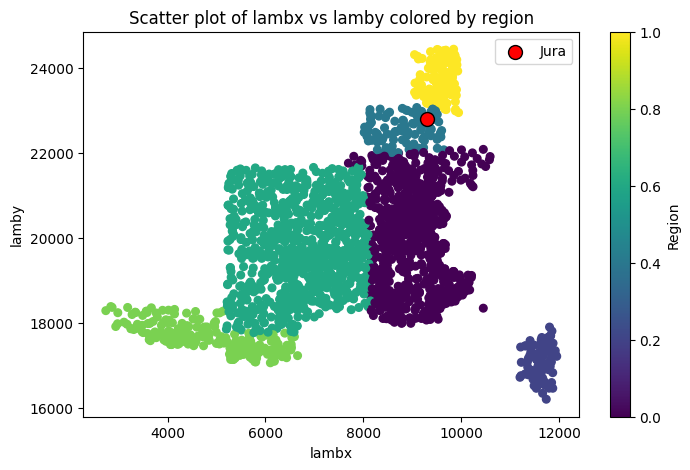

In [8]:
from utils.functions import region_to_number

predictors = dataset.reset_coords().drop_vars(['t','Station_Name','reseau_poste_actuel']).isel(time=0).to_dataframe().drop(columns='time')
predictors = predictors[['region', 'lambx', 'lamby']]

poucave = np.random.randint(0, len(predictors))
plt.figure(figsize=(8, 5))
plt.scatter(predictors['lambx'], predictors['lamby'], c=region_to_number(predictors['region']), cmap='viridis', s=30)
plt.scatter(predictors.iloc[poucave]['lambx'], predictors.iloc[poucave]['lamby'], label=predictors["region"].iloc[poucave], color='red', s=100, edgecolor='black')
plt.legend()
plt.title('Scatter plot of lambx vs lamby colored by region')
plt.xlabel('lambx')
plt.ylabel('lamby')
plt.colorbar(label='Region')
plt.show()

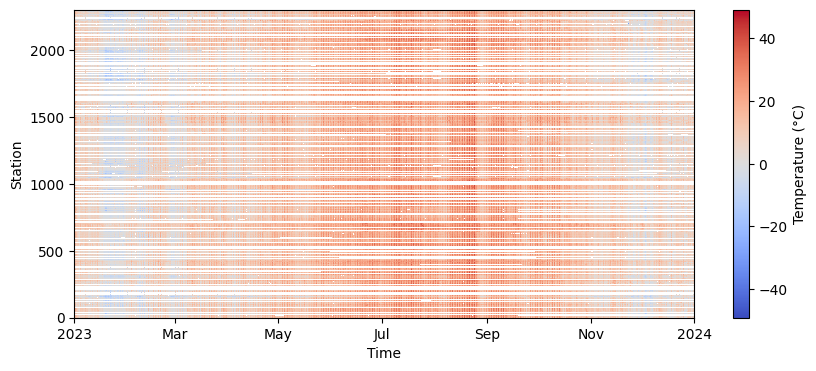

In [9]:
plt.figure(figsize=(10, 4))
dataset['t'].plot(x='time', y='station_count', cbar_kwargs={'label': "Temperature (°C)"}, cmap='coolwarm')
plt.xlabel("Time")
plt.ylabel("Station")
plt.show()

Text(0.5, 1.0, 'station "ARBENT"')

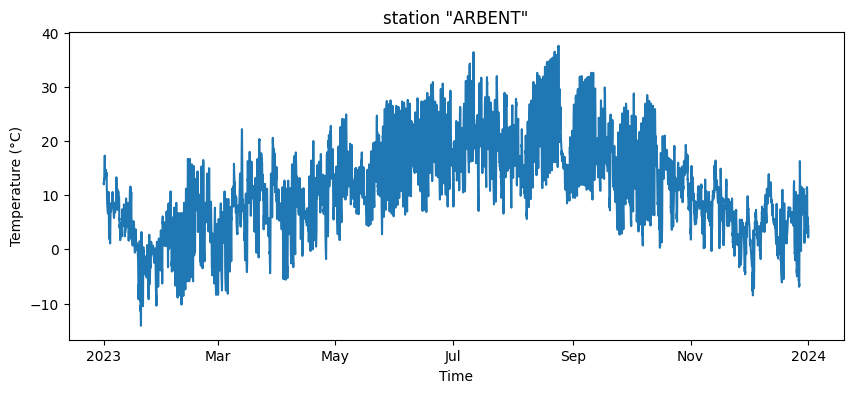

In [10]:
plt.figure(figsize=(10, 4))
dataset['t'].sel(num_poste=0, method='nearest').plot(x='time')
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("station \"ARBENT\"")

In [11]:
from data_provider.data_provider import DataProvider
from types import SimpleNamespace

In [12]:
args = SimpleNamespace()
args.data = 'bdclim_clean'
args.dataset = 'SequenceMaskDataset'
args.root_path = '../datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 1
args.window = 24*30*1
args.mask_proba = 0.5

data_provider = DataProvider(args)
X_train, y_train = data_provider.train_dataset[:]

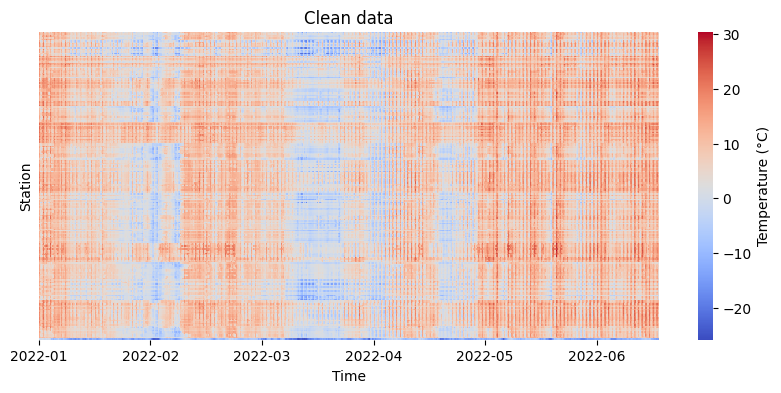

In [13]:
import pandas as pd

plt.figure(figsize=(10, 4))
sns.heatmap(y_train.T, yticklabels=False, cmap="coolwarm", cbar_kws={'label': "Temperature (°C)"})
start_time = pd.to_datetime('2022-01-12')
datetime = [start_time + pd.Timedelta(hours=i) for i in range(X_train.shape[0])]
plt.xticks(ticks=np.arange(0, len(datetime), 24*30), labels=[datetime[i].strftime('%Y-%m') for i in range(0, len(datetime), 24*30)], rotation=0)
plt.xlabel("Time")
plt.ylabel("Station")
plt.title("Clean data")
plt.show()

### Baseline <a class="anchor" id="second-bullet"></a>

In [14]:
from data_provider.data_provider import DataProvider
from models.baseline import mean_fill, svd, linear

from types import SimpleNamespace
from sklearn.metrics import mean_squared_error

In [15]:
args = SimpleNamespace()
args.data = 'bdclim_clean'
args.dataset = 'SampleMaskDataset'
args.root_path = '../datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 10
args.mask_proba = 0.5

data_provider = DataProvider(args)

optimal rank: 11


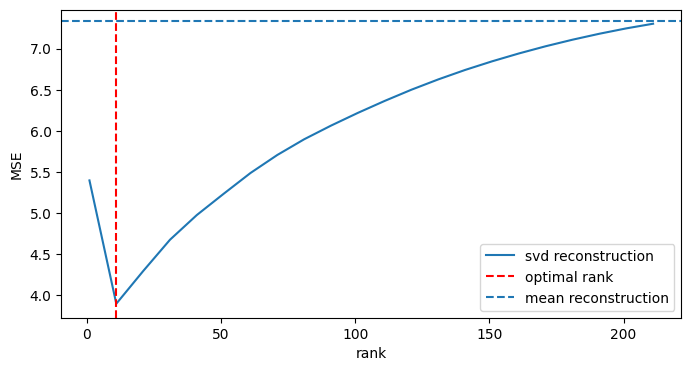

In [16]:
X_train, y_train = data_provider.train_dataset[:]

mean_model = mean_fill()

svd_model = svd()
svd_model.train(torch.FloatTensor(X_train), torch.FloatTensor(y_train), verbose=True)

linear_model = linear()
linear_model.train(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

In [17]:
X_test, y_test = data_provider.test_dataset[:]

y_pred_mean = mean_model(torch.FloatTensor(X_test))
MSE_mean = mean_squared_error(y_pred_mean, y_test)

y_pred_svd = svd_model.predict(torch.FloatTensor(X_test))
MSE_svd = mean_squared_error(y_pred_svd, y_test)

y_pred_linear = linear_model.predict(torch.FloatTensor(X_test))
MSE_linear = mean_squared_error(y_pred_linear, y_test)

print(f'MSE Mean: {MSE_mean}, MSE SVD: {MSE_svd}, MSE Linear: {MSE_linear}')

MSE Mean: 36.52435578241779, MSE SVD: 3.843224890866176, MSE Linear: 1.4753714316220166


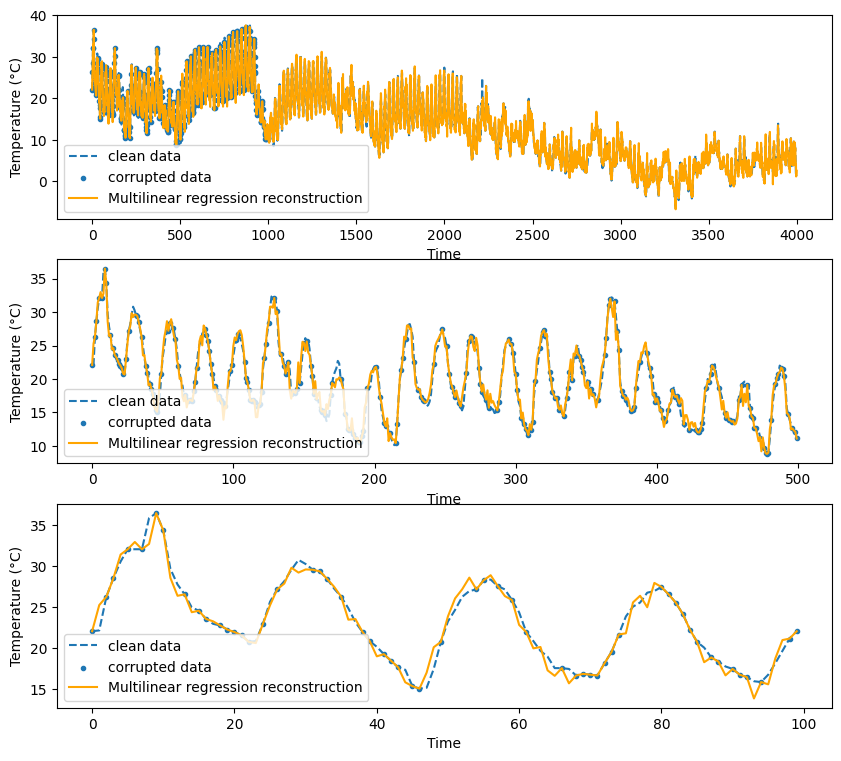

In [18]:
station = np.random.choice(np.arange(0, X_test.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=(10, 9))
ax[0].plot(y_test[:,station], label='clean data', linestyle='--')
ax[0].scatter(np.arange(0, X_test.shape[0])[:1000], X_test[:,station][:1000], label='corrupted data', marker='.')
ax[0].plot(y_pred_linear[:,station], label='Multilinear regression reconstruction', color='orange')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend(loc='lower left')
ax[1].plot(y_test[:500,station], label='clean data', linestyle='--')
ax[1].scatter(np.arange(0, X_test.shape[0])[:500], X_test[:500,station], label='corrupted data', marker='.')
ax[1].plot(y_pred_linear[:500,station], label='Multilinear regression reconstruction', color='orange')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Temperature (°C)')
ax[1].legend(loc='lower left')
ax[2].plot(y_test[:100,station], label='clean data', linestyle='--')
ax[2].scatter(np.arange(0, X_test.shape[0])[:100], X_test[:100,station], label='corrupted data', marker='.')
ax[2].plot(y_pred_linear[:100,station], label='Multilinear regression reconstruction', color='orange')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Temperature (°C)')
ax[2].legend(loc='lower left')

### Robustness to masking <a class="anchor" id="third-bullet"></a>

In [19]:
from data_provider.data_provider import DataProvider
from types import SimpleNamespace
from experiments.experiments import masking_robustness_baseline

In [20]:
args = SimpleNamespace()
args.data = 'bdclim_clean'
args.dataset = 'SampleMaskDataset'
args.root_path = '../datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 1

probas, MSE_mean, MSE_svd, MSE_linear = masking_robustness_baseline(args)

100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


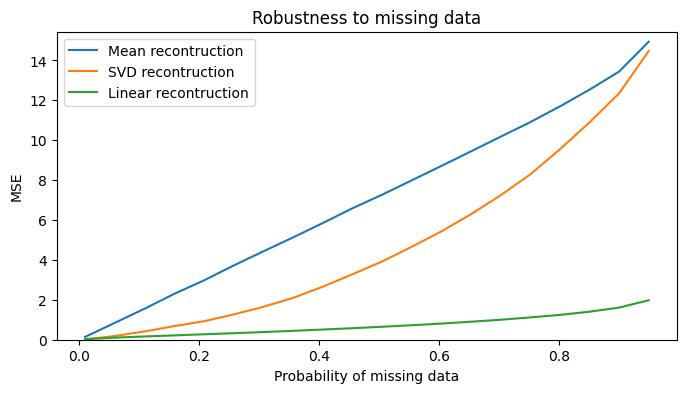

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(probas, MSE_mean, label='Mean recontruction')
plt.plot(probas, MSE_svd, label='SVD recontruction')
plt.plot(probas, MSE_linear, label='Linear recontruction')
plt.ylim(0, max(MSE_mean)+.5)
plt.xlabel("Probability of missing data")
plt.ylabel("MSE")
plt.legend()
plt.title("Robustness to missing data")
plt.show()

## Sequence masking  <a class="anchor" id="fourth-bullet"></a>

In [22]:
from data_provider.data_provider import DataProvider
from types import SimpleNamespace

In [23]:
args = SimpleNamespace()
args.data = 'bdclim_clean'
args.dataset = 'SequenceMaskDataset'
args.root_path = '../datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 1
args.window = 24*10
args.mask_proba = 0.9

data_provider = DataProvider(args)
X_train, y_train = data_provider.train_dataset[:]

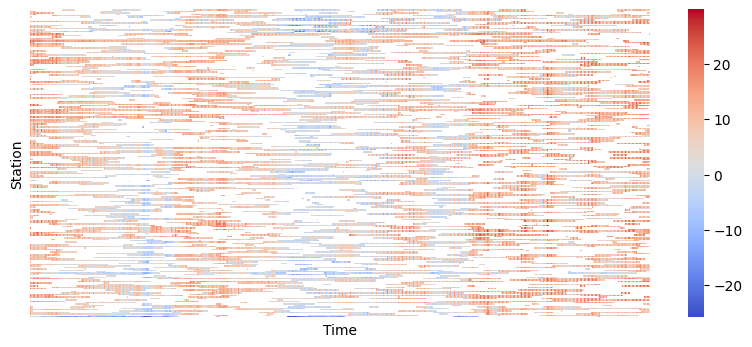

In [24]:
plt.figure(figsize=(10, 4))
sns.heatmap(X_train.T, xticklabels=False, yticklabels=False, cmap="coolwarm")
plt.xlabel("Time")
plt.ylabel("Station")
plt.show()

In [25]:
mean_model = mean_fill(columnwise=True)

svd_model = svd()
svd_model.train(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

linear_model = linear()
linear_model.train(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

In [26]:
X_test, y_test = data_provider.test_dataset[:]

y_pred_mean = mean_model(torch.FloatTensor(X_test))
MSE_mean = mean_squared_error(y_pred_mean, y_test)

y_pred_svd = svd_model.predict(torch.FloatTensor(X_test))
MSE_svd = mean_squared_error(y_pred_svd, y_test)

y_pred_linear = linear_model.predict(torch.FloatTensor(X_test))
MSE_linear = mean_squared_error(y_pred_linear, y_test)

print(f'MSE Mean: {MSE_mean}, MSE SVD: {MSE_svd}, MSE Linear: {MSE_linear}')

MSE Mean: 8.143935241907943, MSE SVD: 6.1439936519088825, MSE Linear: 3.010506988144265


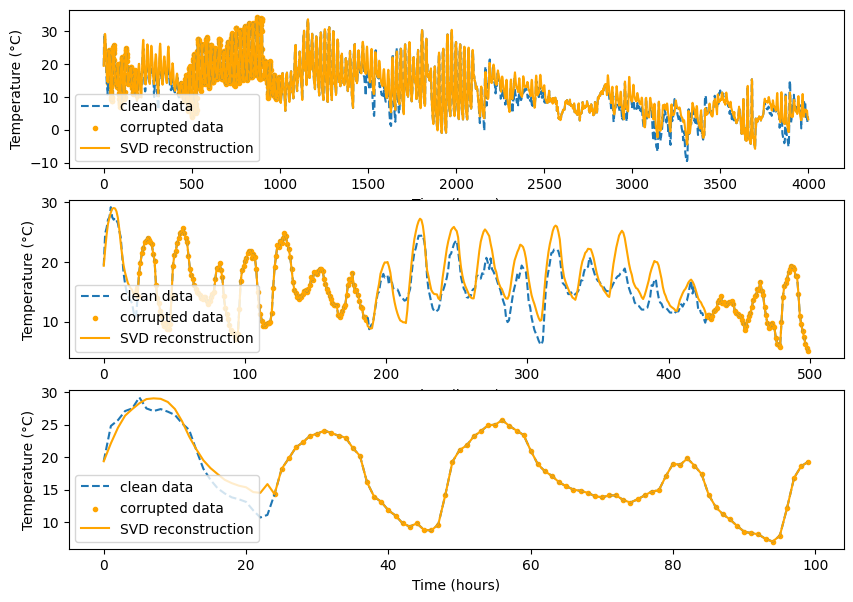

In [27]:
station = np.random.choice(np.arange(0, X_test.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=(10, 7))
ax[0].plot(y_test[:,station], label='clean data', linestyle='--')
ax[0].scatter(np.arange(0, X_test.shape[0])[:1000], X_test[:,station][:1000], label='corrupted data', marker='.', color='orange')
ax[0].plot(y_pred_svd[:,station], label='SVD reconstruction', color='orange')
ax[0].set_xlabel('Time (hours)')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend(loc='lower left')
ax[1].plot(y_test[:500,station], label='clean data', linestyle='--')
ax[1].scatter(np.arange(0, X_test.shape[0])[:500], X_test[:500,station], label='corrupted data', marker='.', color='orange')
ax[1].plot(y_pred_svd[:500,station], label='SVD reconstruction', color='orange')
ax[1].set_xlabel('Time (hours)')
ax[1].set_ylabel('Temperature (°C)')
ax[1].legend(loc='lower left')
ax[2].plot(y_test[:100,station], label='clean data', linestyle='--')
ax[2].scatter(np.arange(0, X_test.shape[0])[:100], X_test[:100,station], label='corrupted data', marker='.', color='orange')
ax[2].plot(y_pred_svd[:100,station], label='SVD reconstruction', color='orange')
ax[2].set_xlabel('Time (hours)')
ax[2].set_ylabel('Temperature (°C)')
ax[2].legend(loc='lower left')

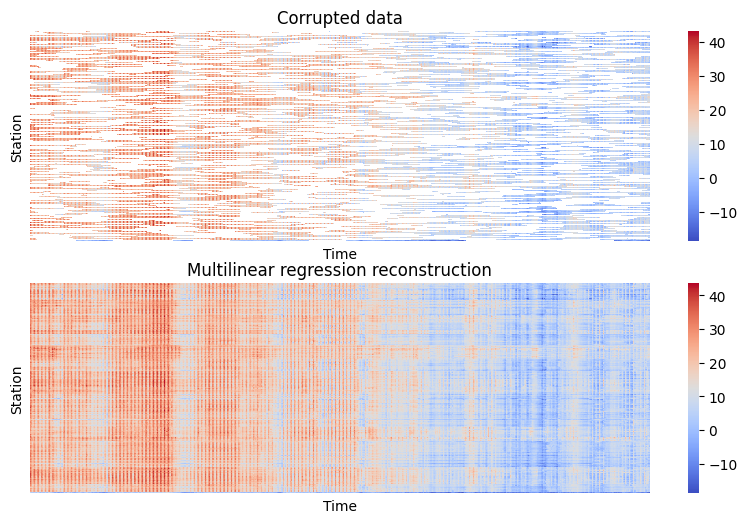

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(X_test.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Corrupted data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(y_pred_linear.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Multilinear regression reconstruction")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()

## Machine learning paradigm <a class="anchor" id="fifth-bullet"></a>

In [312]:
from data_provider.data_provider import DataProvider
from models.baseline import linear_MLP
from experiments.basics import train

from types import SimpleNamespace
from sklearn.metrics import mean_squared_error

In [313]:
args = SimpleNamespace()
args.data = 'bdclim_clean'
args.dataset = 'SequenceMaskDataset'
args.root_path = '../datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 100
args.window = 24*30
args.mask_proba = 0.9

data_provider = DataProvider(args)
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

In [314]:
linear_MLP_model = linear_MLP(seq_dim=data_provider.data.n_nodes)
train_loss, test_loss = train(model=linear_MLP_model, 
                              train_dataloader=train_dataloader, 
                              test_dataloader=test_dataloader, 
                              lr=0.001, epochs=100)

100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


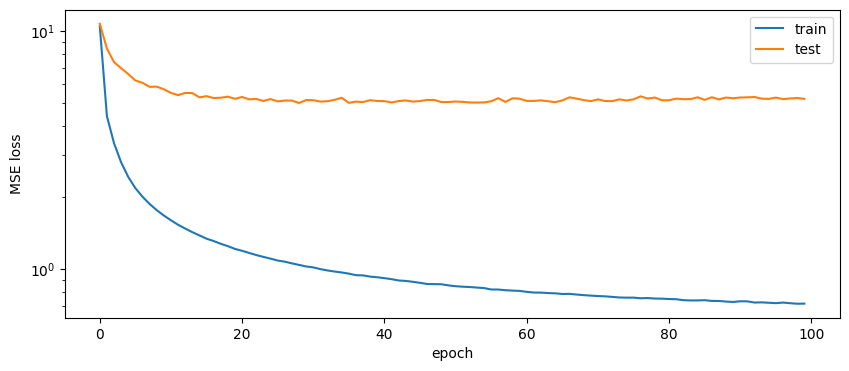

In [315]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

In [316]:
X_test, y_test = data_provider.test_dataset[:]

y_pred_linear = linear_MLP_model(torch.FloatTensor(X_test)).detach().numpy()
MSE_linear = mean_squared_error(y_pred_linear, y_test)

print(f'MSE Linear MLP: {MSE_linear}')

MSE Linear MLP: 5.176958116556287


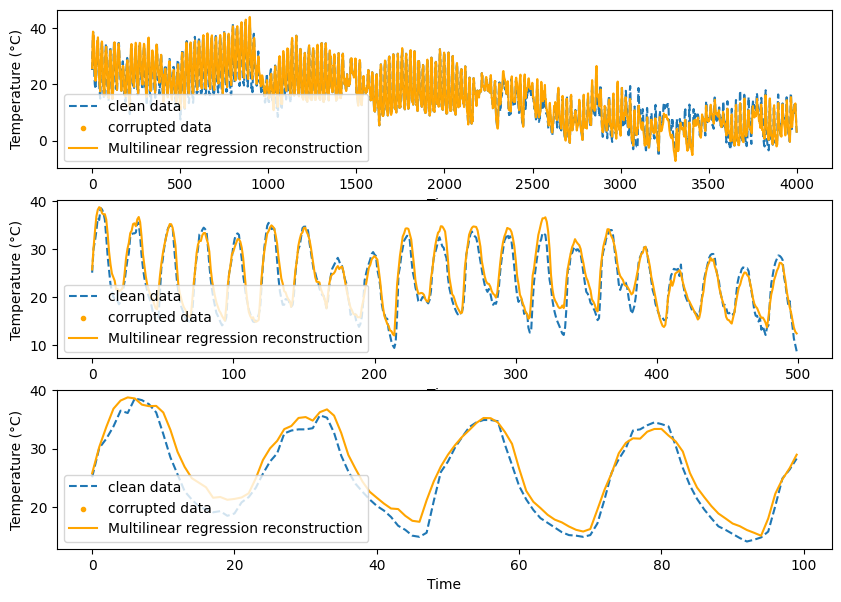

In [317]:
station = np.random.choice(np.arange(0, X_test.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=(10, 7))
ax[0].plot(y_test[:,station], label='clean data', linestyle='--')
ax[0].scatter(np.arange(0, X_test.shape[0])[:1000], X_test[:,station][:1000], label='corrupted data', marker='.', color='orange')
ax[0].plot(y_pred_linear[:,station], label='Multilinear regression reconstruction', color='orange')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend(loc='lower left')
ax[1].plot(y_test[:500,station], label='clean data', linestyle='--')
ax[1].scatter(np.arange(0, X_test.shape[0])[:500], X_test[:500,station], label='corrupted data', marker='.', color='orange')
ax[1].plot(y_pred_linear[:500,station], label='Multilinear regression reconstruction', color='orange')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Temperature (°C)')
ax[1].legend(loc='lower left')
ax[2].plot(y_test[:100,station], label='clean data', linestyle='--')
ax[2].scatter(np.arange(0, X_test.shape[0])[:100], X_test[:100,station], label='corrupted data', marker='.', color='orange')
ax[2].plot(y_pred_linear[:100,station], label='Multilinear regression reconstruction', color='orange')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Temperature (°C)')
ax[2].legend(loc='lower left')

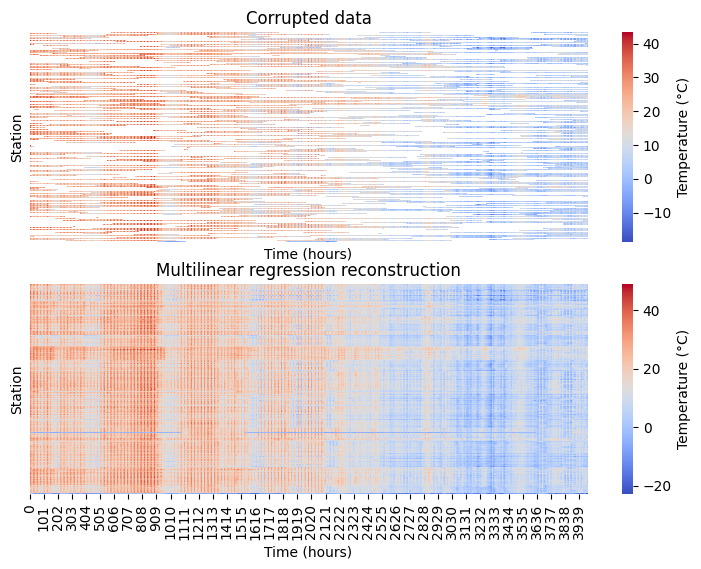

In [318]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
sns.heatmap(X_test.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0], cbar_kws={'label': "Temperature (°C)"})
ax[0].set_title("Corrupted data")
ax[0].set_xlabel("Time (hours)")
ax[0].set_ylabel("Station")
sns.heatmap(y_pred_linear.T, yticklabels=False, cmap="coolwarm", ax=ax[1], cbar_kws={'label': "Temperature (°C)"})
ax[1].set_title("Multilinear regression reconstruction")
ax[1].set_xlabel("Time (hours)")
ax[1].set_ylabel("Station")
plt.show()

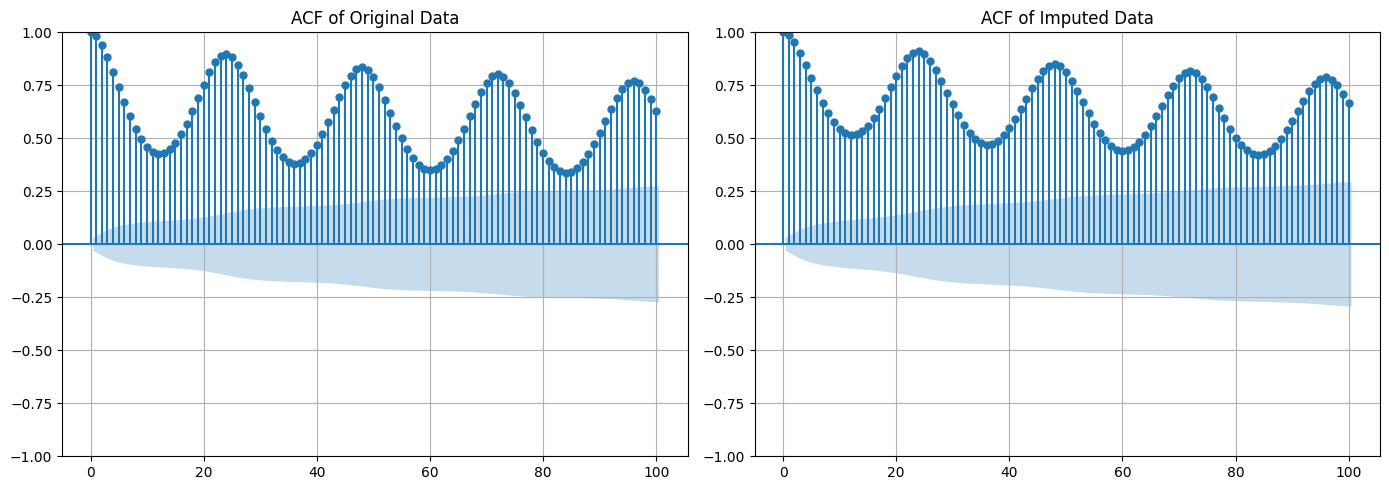

In [326]:
import statsmodels.api as sm

clean_data = pd.DataFrame(y_test, columns=[f'Station_{i}' for i in range(y_test.shape[1])])
reconstructed_data = pd.DataFrame(y_pred_linear, columns=[f'Station_{i}' for i in range(y_pred_linear.shape[1])])

def plot_acf_comparison(original_series, imputed_series, lags=100):
    plt.figure(figsize=(14, 5))

    # Original Data ACF
    plt.subplot(1, 2, 1)
    sm.graphics.tsa.plot_acf(original_series.dropna(), lags=lags, ax=plt.gca(), title="ACF of Original Data")
    plt.grid(True)

    # Imputed Data ACF
    plt.subplot(1, 2, 2)
    sm.graphics.tsa.plot_acf(imputed_series, lags=lags, ax=plt.gca(), title="ACF of Imputed Data")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

random_station = np.random.choice(clean_data.columns)
plot_acf_comparison(clean_data[random_station], reconstructed_data[random_station])

## Deep MLP <a class="anchor" id="sixth-bullet"></a>

In [36]:
from data_provider.data_provider import DataProvider
from models.MLP import MLP
from experiments.basics import train

from types import SimpleNamespace
from sklearn.metrics import mean_squared_error

In [37]:
args = SimpleNamespace()
args.data = 'bdclim_clean'
args.dataset = 'SequenceMaskDataset'
args.root_path = '../datasets/'
args.data_path = 'bdclim_safran_2022-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 100
args.window = 24*30*1
args.mask_proba = 0.7

data_provider = DataProvider(args)
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

In [38]:
MLP_model = MLP(seq_dim=data_provider.data.n_nodes, hidden_dim=4*data_provider.data.n_nodes)
train_loss, test_loss = train(model=MLP_model, 
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader, 
                              lr=0.001, epochs=100)

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


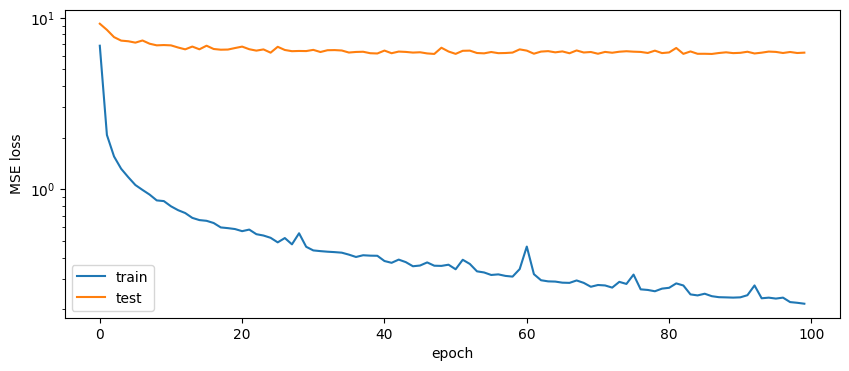

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

In [40]:
X_test, y_test = data_provider.test_dataset[:]

y_pred_MLP = MLP_model(torch.FloatTensor(X_test)).detach().numpy()
MSE_MLP = mean_squared_error(y_pred_MLP, y_test)

print(f'MSE Linear MLP: {MSE_MLP}')

MSE Linear MLP: 6.260886313829902


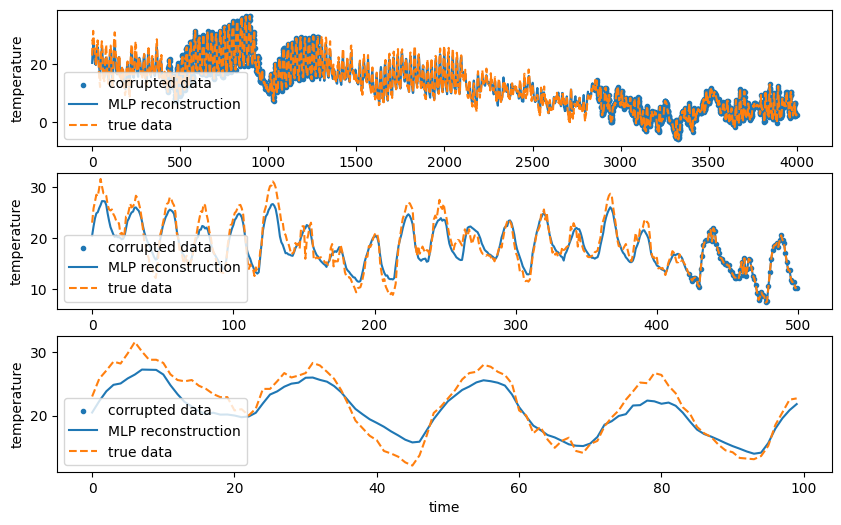

In [41]:
station = np.random.choice(np.arange(0, X_test.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].scatter(np.arange(0, X_test.shape[0]), X_test[:,station], label='corrupted data', marker='.')
ax[0].plot(y_pred_MLP[:,station], label='MLP reconstruction')
ax[0].plot(y_test[:,station], label='true data', linestyle='--')
ax[0].set_xlabel('time')
ax[0].set_ylabel('temperature')
ax[0].legend(loc='lower left')
ax[1].scatter(np.arange(0, X_test.shape[0])[:500], X_test[:500,station], label='corrupted data', marker='.')
ax[1].plot(y_pred_MLP[:500,station], label='MLP reconstruction')
ax[1].plot(y_test[:500,station], label='true data', linestyle='--')
ax[1].set_xlabel('time')
ax[1].set_ylabel('temperature')
ax[1].legend(loc='lower left')
ax[2].scatter(np.arange(0, X_test.shape[0])[:100], X_test[:100,station], label='corrupted data', marker='.')
ax[2].plot(y_pred_MLP[:100,station], label='MLP reconstruction')
ax[2].plot(y_test[:100,station], label='true data', linestyle='--')
ax[2].set_xlabel('time')
ax[2].set_ylabel('temperature')
ax[2].legend(loc='lower left')

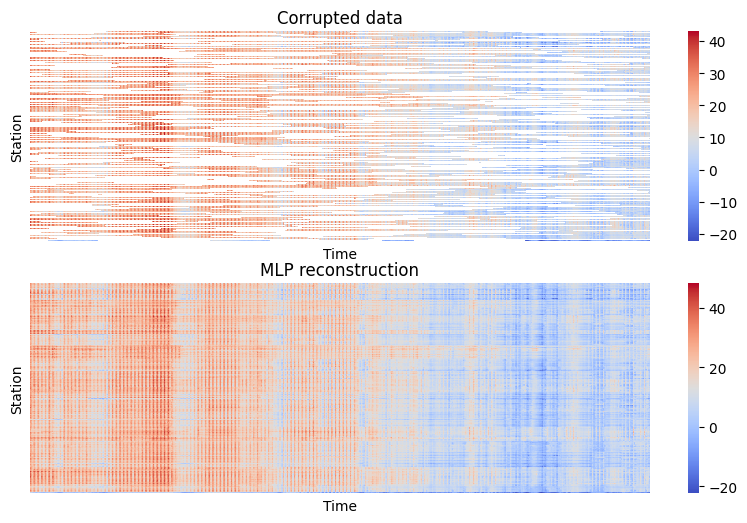

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(X_test.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Corrupted data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(y_pred_linear.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("MLP reconstruction")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()

## Graph inference <a class="anchor" id="seventh-bullet"></a>

In [43]:
from data_provider.data_provider import DataProvider

from types import SimpleNamespace
import networkx as nx
import scipy.sparse

/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


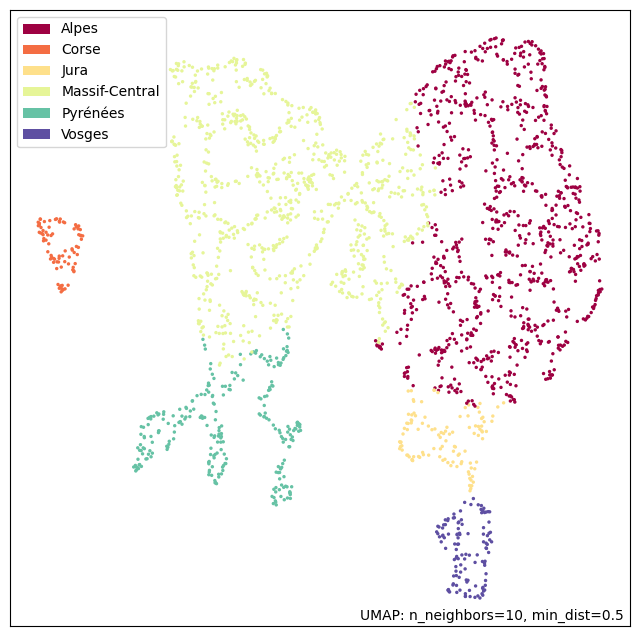

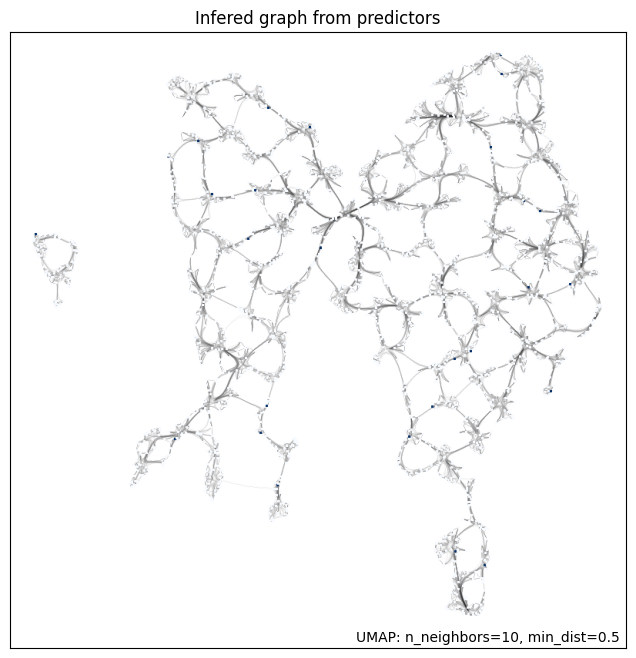

In [44]:
args = SimpleNamespace()
args.data = 'bdclim'
args.dataset = 'SequenceMaskDataset'
args.root_path = '../datasets/'
args.data_path = 'bdclim_safran_2023-2024.nc'
args.scaler = None
args.batch_size = 100
args.window = 24*30*1
args.mask_proba = 0.7

data_provider = DataProvider(args)
adjacency_matrix = data_provider.data.umap_adjacency(threshold=0.1, verbose=True)
ordered_indices = scipy.sparse.csgraph.reverse_cuthill_mckee(graph=scipy.sparse.csr_matrix(adjacency_matrix), symmetric_mode=True)
ordered_adjacency_matrix = adjacency_matrix[ordered_indices, :][:, ordered_indices]

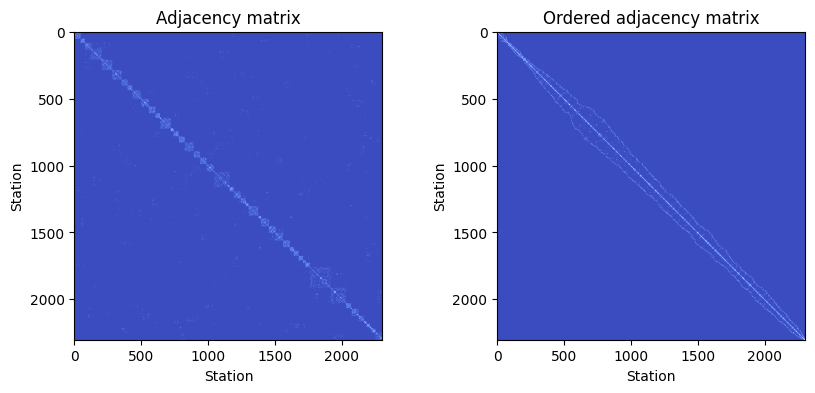

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(adjacency_matrix, cmap='coolwarm')
ax[0].set_title("Adjacency matrix")
ax[0].set_xlabel("Station")
ax[0].set_ylabel("Station")
ax[1].imshow(ordered_adjacency_matrix, cmap='coolwarm')
ax[1].set_title("Ordered adjacency matrix")
ax[1].set_xlabel("Station")
ax[1].set_ylabel("Station")
plt.show()

Text(0.5, 1.0, 'Ordered infered graph')

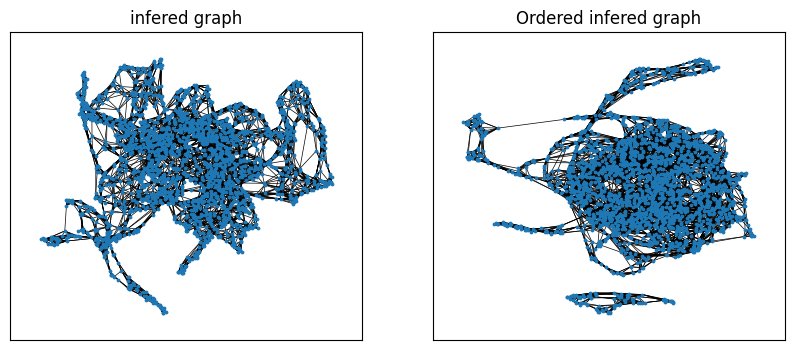

In [46]:
G = nx.from_numpy_array(adjacency_matrix)
G_ordered = nx.from_numpy_array(ordered_adjacency_matrix)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
nx.draw_networkx(G, with_labels=False, node_size=3, width=0.5, ax=ax[0])
ax[0].set_title("infered graph")
nx.draw_networkx(G_ordered,  with_labels=False, node_size=3, width=0.5, ax=ax[1])
ax[1].set_title("Ordered infered graph")

## GRIN <a class="anchor" id="eighth-bullet"></a>

In [363]:
from data_provider.data_provider import DataProvider
from models.GRIN import GRINet 
from fillers.WindowHorizonFiller import WindowHorizonFiller

from types import SimpleNamespace

1
1
1
1
1
1
1
1
1
1
1
1
X shape: torch.Size([4032, 219]), y shape: torch.Size([4032, 219]), mask shape: torch.Size([4032, 219])


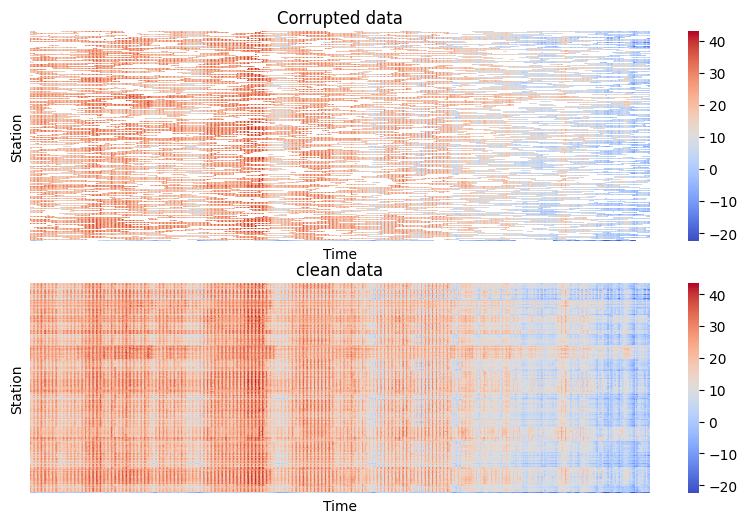

In [364]:
# dataset
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../datasets/'
data_kwargs.data_path = 'bdclim_safran_2022-2024.nc'
data_kwargs.scaler = None
data_kwargs.batch_size = 1
data_kwargs.window = 24*7*2
data_kwargs.horizon = 0
data_kwargs.mask_proba = 0.5
data_kwargs.mask_length = 24*7*1

data_provider = DataProvider(data_kwargs)
adjacency_matrix = torch.FloatTensor(data_provider.data.umap_adjacency(threshold=0.1, verbose=False))
#adjacency_matrix = torch.FloatTensor(data_provider.data.correlation_adjacency())
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

x, y, mask = [], [], []
for batch in test_dataloader:
    print(1)
    x_, y_, mask_ = batch.pop('x').view(-1, data_provider.data.n_nodes, 1), batch.pop('y').view(-1, data_provider.data.n_nodes, 1), batch.pop('mask').view(-1, data_provider.data.n_nodes, 1)
    x.append(x_)
    y.append(y_)
    mask.append(mask_)
x = torch.cat(x, dim=0).squeeze(2)
y = torch.cat(y, dim=0).squeeze(2)
mask = torch.cat(mask, dim=0).squeeze(2)

print(f"X shape: {x.shape}, y shape: {y.shape}, mask shape: {mask.shape}")

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(x.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Corrupted data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(y.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("clean data")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()

In [365]:
# predictors
model_kwargs = dict(adj=adjacency_matrix, d_in=1)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 0.01
filler_kwargs.epochs = 10
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = WindowHorizonFiller(GRINet, model_kwargs, filler_kwargs)

# load model
filler.load_model('GRINet.pt')

In [366]:
train_loss, test_loss = filler.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader, verbose=True)

#save model 
filler.save_model('GRINet.pt')

 10%|█         | 1/10 [02:06<18:54, 126.02s/it]

Epoch 1/10, Train Loss: 9.83225396, Test Loss: 21.31729766


 20%|██        | 2/10 [04:18<17:17, 129.71s/it]

Epoch 2/10, Train Loss: 8.49474525, Test Loss: 14.74231046


 30%|███       | 3/10 [06:30<15:15, 130.73s/it]

Epoch 3/10, Train Loss: 11.23362305, Test Loss: 11.85141544


 40%|████      | 4/10 [08:35<12:51, 128.56s/it]

Epoch 4/10, Train Loss: 5.36775259, Test Loss: 5.96775024


 50%|█████     | 5/10 [10:38<10:32, 126.44s/it]

Epoch 5/10, Train Loss: 14.58593963, Test Loss: 4.96521890


 60%|██████    | 6/10 [12:37<08:16, 124.09s/it]

Epoch 6/10, Train Loss: 3.53350310, Test Loss: 3.44261596


 70%|███████   | 7/10 [14:27<05:57, 119.32s/it]

Epoch 7/10, Train Loss: 2.96886237, Test Loss: 3.70551160


 80%|████████  | 8/10 [16:25<03:57, 118.86s/it]

Epoch 8/10, Train Loss: 2.55592973, Test Loss: 3.26953046


 90%|█████████ | 9/10 [18:17<01:56, 116.77s/it]

Epoch 9/10, Train Loss: 2.41604754, Test Loss: 2.80319792


100%|██████████| 10/10 [20:09<00:00, 120.99s/it]

Epoch 10/10, Train Loss: 2.37558472, Test Loss: 2.83994403


[9.832253962755203, 8.494745254516602, 11.23362304766973, 5.367752591768901, 14.585939625898996, 3.5335030953089395, 2.9688623746236167, 2.5559297303358712, 2.416047543287277, 2.3755847215652466]


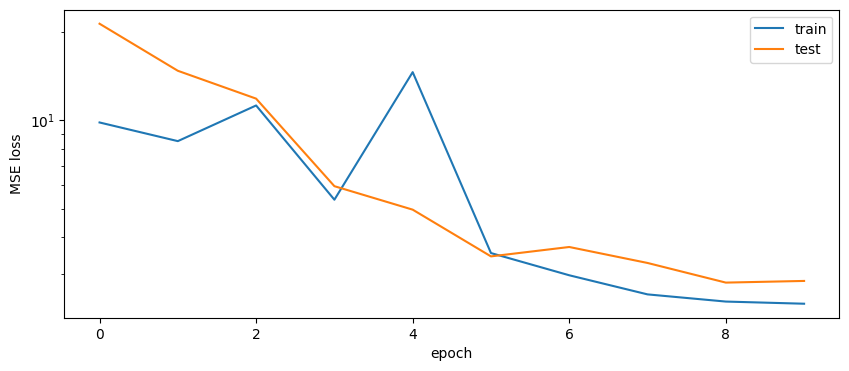

In [367]:
print(train_loss)

plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()

In [368]:
y_hat = filler.impute_dataset(test_dataloader, data_provider)

Imputed data shape: (4032, 219)


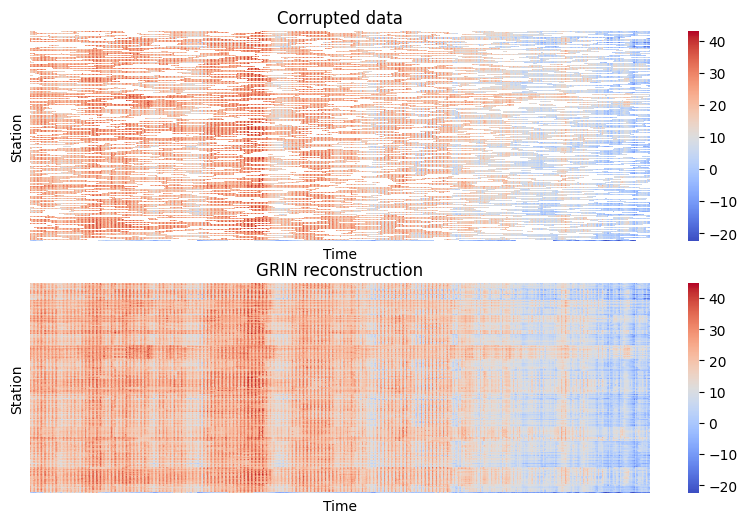

In [369]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.heatmap(x.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Corrupted data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(y_hat.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1])
ax[1].set_title("GRIN reconstruction")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
plt.show()

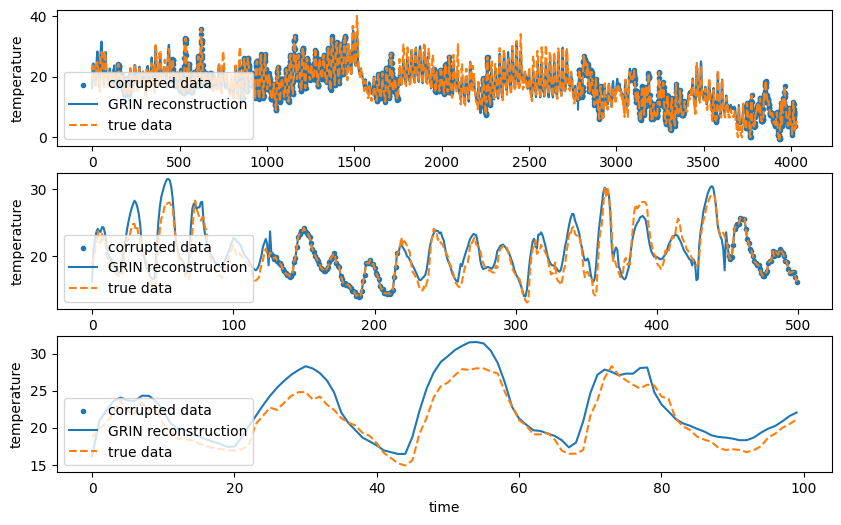

In [381]:
station = np.random.choice(np.arange(0, x.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].scatter(np.arange(0, x.shape[0]), x[:,station], label='corrupted data', marker='.')
ax[0].plot(y_hat[:,station], label='GRIN reconstruction')
ax[0].plot(y[:,station], label='true data', linestyle='--')
ax[0].set_xlabel('time')
ax[0].set_ylabel('temperature')
ax[0].legend(loc='lower left')
ax[1].scatter(np.arange(0, x.shape[0])[:500], x[:500,station], label='corrupted data', marker='.')
ax[1].plot(y_hat[:500,station], label='GRIN reconstruction')
ax[1].plot(y[:500,station], label='true data', linestyle='--')
ax[1].set_xlabel('time')
ax[1].set_ylabel('temperature')
ax[1].legend(loc='lower left')
ax[2].scatter(np.arange(0, x.shape[0])[:100], x[:100,station], label='corrupted data', marker='.')
ax[2].plot(y_hat[:100,station], label='GRIN reconstruction')
ax[2].plot(y[:100,station], label='true data', linestyle='--')
ax[2].set_xlabel('time')
ax[2].set_ylabel('temperature')
ax[2].legend(loc='lower left')

## Evaluation metrics <a class="anchor" id="nineth-bullet"></a>

In [382]:
from experiments.evaluation import statistical_comparison, autocorrelation, seasonal_analysis

Metric  Original Data  Imputed Data (GRIN)
0  count    1956.000000          4032.000000
1   mean      16.646575            16.230394
2    std       9.249432             8.371052
3    min      -6.600000            -6.600000
4    25%      10.475000            10.385382
5    50%      16.000000            16.000000
6    75%      23.025000            22.170765
7    max      37.400000            37.400002

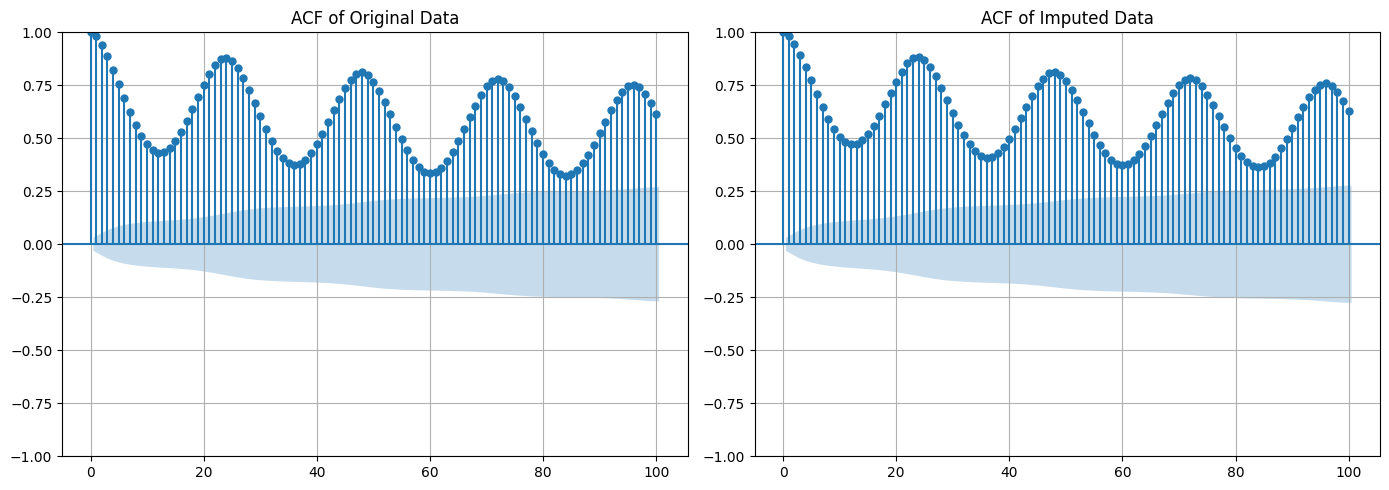

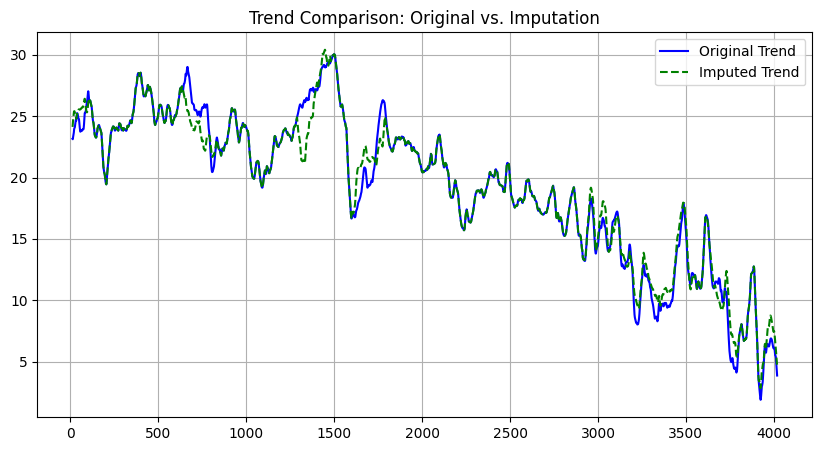

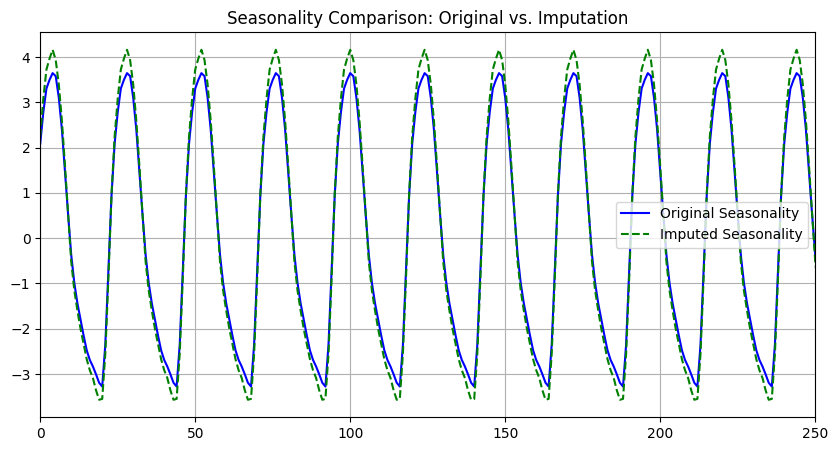

In [437]:
stats = statistical_comparison(x, y_hat)
autocorrelation(y, y_hat)
seasonal_analysis(y, y_hat)